In [1]:
!pip install nltk


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
from nltk.corpus import brown
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)

[nltk_data] Downloading package brown to /Users/anonymous/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

main task translation = give 26 positions vector that indicates letters consisted in word, no positional vector, make NN spell the word like doing scrabble. <br> 
also do = create storage of the index of these words, where key = word, value = index <br>
also do = target list -> [indexes of words]

In [4]:
class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        words = brown.words()
        lowercase_words = [word.lower() for word in words] # Convert all words to lowercase
        seen = set()
        unique_words = [] # Create a list of unique words
        for word in lowercase_words:
            if word not in seen and len(word) > 1 and all(letter in string.ascii_lowercase for letter in word):
                unique_words.append(word)
                seen.add(word)
            if len(unique_words) == 5000:
                break
    
        self.data = unique_words # Load the first 5000 words from the Brown corpus
        self.word_to_idx = {word: idx for idx, word in enumerate(self.data)} # Convert the unique words to an index dictionary {word: index}
        self.targets = list(range(len(self.data))) # Make these indexes the target values


    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.
       
        vector = [0] * 26  # Initialize a vector of size 26 with all zeros
        for letter in x:
            if letter not in string.ascii_lowercase:
                raise ValueError(f"Invalid character '{letter}' in word '{x}'")
            vector[ord(letter) - ord('a')] += 1  # using ord to get the index of the letter in the alphabet as an index of position in vector, then increment value
        x = vector
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
    

#### Test validity of the module

In [5]:
dataset = AlphaDataset()
print(len(dataset))  # Should be 5000
print(dataset[0])    # Should return a tuple: (tensor, label)
print(dataset[0][0].shape)  # Should be (26,)
print(dataset[0][1].shape)  # Should be (1,)
print(dataset.data[0])  # Should return the first word in the dataset

5000
(tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.]), tensor(0))
torch.Size([26])
torch.Size([])
the


### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()
        # Implement the neural network layers, the activation function is already defined
        self.input_layer = nn.Linear(input_size, hidden_size[0])
        self.hidden_layer = nn.Linear(hidden_size[0], hidden_size[1])
        self.output_layer = nn.Linear(hidden_size[1], output_size)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # In the forward pass the model will calculate the gradients as well as the probabilities of the result occuring given its input.
        # Implement the missing layers

        x = self.input_layer(x) # Implement input layer
        x = self.activation(x)
        x = self.hidden_layer(x) # Implement hidden layer
        x = self.activation(x)
        x = self.output_layer(x) # Implement the output layer

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [7]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'cpu' # If you have an m1 macbook use: 'mbp', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [8]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [9]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [10]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

Training_loss: 8.545825958251953
Validation_loss: 1.069791624546051
Training_loss: 8.472640037536621
Validation_loss: 1.0807845091819763
Training_loss: 8.361360549926758
Validation_loss: 1.0989296507835389
Training_loss: 8.224590301513672
Validation_loss: 1.1296512818336486
Training_loss: 8.04572868347168
Validation_loss: 1.175230004787445
Training_loss: 7.941717147827148
Validation_loss: 1.2318993186950684
Training_loss: 7.761641025543213
Validation_loss: 1.2939287114143372
Training_loss: 7.4719929695129395
Validation_loss: 1.357236874103546
Training_loss: 7.459012031555176
Validation_loss: 1.4203835105895997
Training_loss: 7.381588935852051
Validation_loss: 1.4833846879005432
Training_loss: 7.579195022583008
Validation_loss: 1.5469211983680724
Training_loss: 7.425624847412109
Validation_loss: 1.6118648767471313
Training_loss: 7.056424140930176
Validation_loss: 1.6786361598968507
Training_loss: 7.1695027351379395
Validation_loss: 1.747578773498535
Training_loss: 7.079358100891113
Vali

### Writing
Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?

#### Answer:
The validation loss increasing while the training loss decreases signals that the model with initial random weights and biases performs the best on the validation set, better than any future model that was updated during training. Training actually made the performance of the model on the validation set worse, indicating that it never learns any useful patterns for generalization. This occurs because the bag-of-letters representation creates fundamental ambiguities. Many different words map to identical input vectors (e.g. "tea" and "eat"), forcing the model to learn training-set-specific mappings that don't transfer to the validation set. The training loss continuously decreasing aligns with this assessment. Each training step moves the model further away from the accidentally useful parameters toward training-specific memorization, resulting in a highly overfitted model.

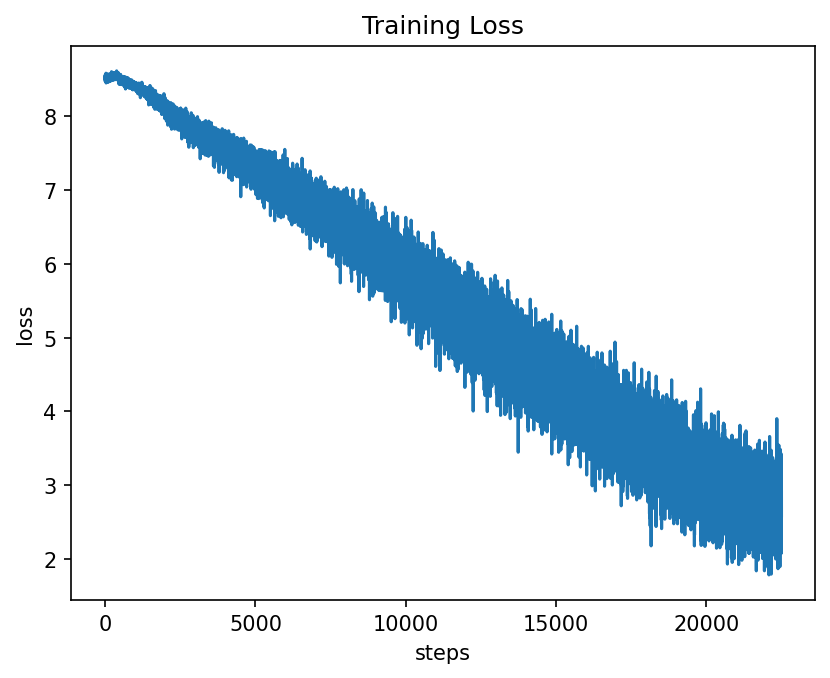

In [11]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

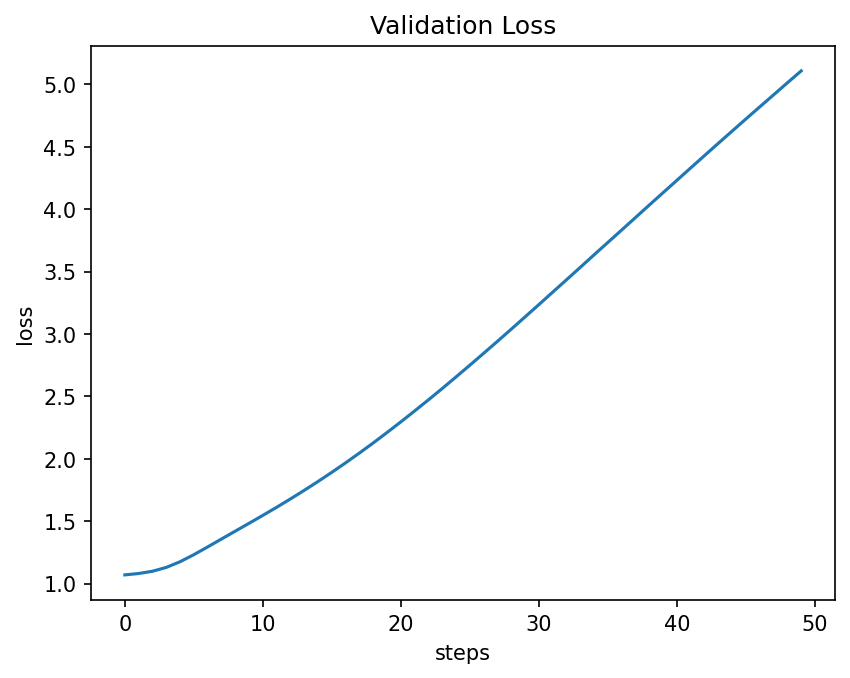

In [12]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
Below we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?

#### Answer:
This example points to a fundamental flaw of the input representation. The input does not encode the position of the letters, it merely counts their presence. For instance, "charter" and "rather" share a very similar word vector that only differentiates at the position for 'c', where "charter" will encode a one and "rather" a zero. Having never encountered the word "rather" during training, the model likely learned to assign very low probabilities to such classes that were not present in the training set. Therefore predicting the word with the most similar word vector ("charter") that it did see. This phenomenon can be observed for all other words.

In [13]:
def get_n_words(dataset, n, model, ds, verbose = True):
    if n == -1:
        n = len(dataset)
    x = [dataset.__getitem__(i)[0] for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    target_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in y]
    out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
    predicted_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in out]
    width = max(len(word) for word in target_words) + 5
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    return target_words, predicted_words

_,_ = get_n_words(test_dataset, 10, model, dataset)

target: rather           predicted: charter
target: private          predicted: privately
target: novel            predicted: lemon
target: cooperate        predicted: operate
target: preliminary      predicted: kremlin
target: order            predicted: recorded
target: advertising      predicted: investigations
target: created          predicted: exacerbated
target: elect            predicted: elected
target: texans           predicted: absent


/var/folders/l9/ktthm47x39n329gvdz4tbyyw0000gn/T/ipykernel_53076/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


Why are some words incorrectly predicted?

#### Answer:
Words are incorrectly predicted because their set of letters have a large intersection. Words such as "tea" and "eat" are represented as the same vector, despite their semantic difference. In simple words, the arrangement of letters matters for their meaning. Most target and prediction pairs share a lot of overlapping characters. Some pairs, like "private" and "privately" are even complete subsets to each other. Since the alphabetic representation discards positional information and only counts letter frequencies, words with similar character compositions become indistinguishable to the model, regardless of their semantic differences.

### Code + Written
Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.

#### Answer:
The Jaccard similarity is a set-based metric that measures the similarity between two sets by dividing the size of their intersection by the size of their union: J(A,B) = |A ∩ B| / |A ∪ B| [1]. For words, this translates to counting shared characters divided by total unique characters across both words. The results show fundamentally different patterns between Jaccard and cosine similarity metrics. Jaccard similarity measures character overlap, capturing how many letters two words share regardless of meaning, while cosine similarity from word vectors measures semantic similarity based on contextual co-occurrence patterns learned from large text corpora. For example, "elect" and "elected" show high Jaccard similarity (0.714) due to shared characters but low cosine similarity (0.275) because they function differently grammatically.

#### Reference:
[1] "Jaccard Similarity" GeeksforGeeks, Available: https://www.geeksforgeeks.org/jaccard-similarity/

In [31]:
# Method 1 - Jaccard similarity
from collections import Counter

def jaccard_similarity(target, prediction):
    target = Counter(target)
    prediction = Counter(prediction)

    intersection = sum((target & prediction).values())
    union = sum((target | prediction).values())

    return intersection / union # common occurances / total occurances

# Jaccard similarity for the first ten words
target_words, predicted_words = get_n_words(test_dataset, 10, model, dataset, verbose=False)
print('\n'.join([f'target: {t:<20} predicted: {p:<20} jaccard similarity: {jaccard_similarity(t, p):.3f}' 
                 for t, p in zip(target_words, predicted_words)]))

target: rather               predicted: charter              jaccard similarity: 0.857
target: private              predicted: privately            jaccard similarity: 0.778
target: novel                predicted: lemon                jaccard similarity: 0.667
target: cooperate            predicted: operate              jaccard similarity: 0.778
target: preliminary          predicted: kremlin              jaccard similarity: 0.500
target: order                predicted: recorded             jaccard similarity: 0.625
target: advertising          predicted: investigations       jaccard similarity: 0.562
target: created              predicted: exacerbated          jaccard similarity: 0.636
target: elect                predicted: elected              jaccard similarity: 0.714
target: texans               predicted: absent               jaccard similarity: 0.714


/var/folders/l9/ktthm47x39n329gvdz4tbyyw0000gn/T/ipykernel_53076/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


In [ ]:
# Method 2 - Cosine similarity
import gensim.downloader as api
wv_from_bin = api.load("glove-wiki-gigaword-200")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

In [32]:
def cosine_similarity(target, prediction):
    return wv_from_bin.distance(target, prediction)

# Cosine similarity for the first ten words
target_words, predicted_words = get_n_words(test_dataset, 10, model, dataset, verbose=False)
print('\n'.join([f'target: {t:<20} predicted: {p:<20} cosine similarity: {cosine_similarity(t, p):.3f}' 
                 for t, p in zip(target_words, predicted_words)]))

target: rather               predicted: charter              cosine similarity: 0.711
target: private              predicted: privately            cosine similarity: 0.382
target: novel                predicted: lemon                cosine similarity: 0.888
target: cooperate            predicted: operate              cosine similarity: 0.644
target: preliminary          predicted: kremlin              cosine similarity: 0.837
target: order                predicted: recorded             cosine similarity: 0.786
target: advertising          predicted: investigations       cosine similarity: 0.775
target: created              predicted: exacerbated          cosine similarity: 0.750
target: elect                predicted: elected              cosine similarity: 0.275
target: texans               predicted: absent               cosine similarity: 0.883


/var/folders/l9/ktthm47x39n329gvdz4tbyyw0000gn/T/ipykernel_53076/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
